# Entrenamiento de Modelo LSTM para Predicción de Temperatura
## Usando 3 features del dataset meteorológico

Este notebook entrena un modelo LSTM usando solo 3 columnas del `dataset_ml.csv`:

**Features seleccionadas:**
- **ts**: Temperatura del Aire Seco (°C) → **[OBJETIVO A PREDECIR]**
- **hr**: Humedad Relativa del aire (%)
- **p0**: Presión leída del sensor (hPa)

Este enfoque simplificado permite:
- ✅ Entrenamiento más rápido
- ✅ Modelo más ligero
- ✅ Fácil de mapear con datos de Arduino (temperatura, humedad, presión)
- ✅ Menos riesgo de overfitting

In [17]:
# Imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import joblib
import warnings
warnings.filterwarnings('ignore')

## 1. Cargar y explorar datos

In [18]:
# Cargar datos del dataset completo
csv_path = "modelo stefano/dataset_ml.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print(f"✅ Datos cargados")
print(f"   Total de registros: {len(df):,}")
print(f"   Columnas: {list(df.columns)}")
print(f"\n📊 Primeras filas:")
df.head(10)

✅ Datos cargados
   Total de registros: 3,549,541
   Columnas: ['momento', 'ts', 'td', 'tMin12Horas', 'tMax12Horas', 'tMin24Horas', 'hr', 'p0', 'qfe1', 'qfe2', 'qff', 'qnh', 'tPromedio24h', 'deltaTemp1h', 'deltaPresion1h', 'humedadRelativaCambio']

📊 Primeras filas:


,momento,ts,td,tMin12Horas,tMax12Horas,tMin24Horas,hr,p0,qfe1,qfe2,qff,qnh,tPromedio24h,deltaTemp1h,deltaPresion1h,humedadRelativaCambio
0,2019-01-01 01:00:00,21.9,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.683607,-1.7,0.5,1.2
1,2019-01-01 01:01:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.669355,-1.8,0.5,1.2
2,2019-01-01 01:02:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.2,951.184,1010.2,1012.1,22.655556,-1.8,0.5,1.0
3,2019-01-01 01:03:00,21.8,3.6,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.642187,-1.7,0.5,1.0
4,2019-01-01 01:04:00,21.8,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.629231,-1.7,0.5,0.9
5,2019-01-01 01:05:00,21.7,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.615152,-1.7,0.4,1.0
6,2019-01-01 01:06:00,21.7,3.3,21.0,32.3,32.9,29.7,950.9,951.0,951.184,1010.1,1011.9,22.601493,-1.7,0.4,0.8
7,2019-01-01 01:07:00,21.8,3.3,21.0,32.3,32.9,29.7,951.0,951.1,951.184,1010.1,1012.0,22.589706,-1.6,0.6,0.7
8,2019-01-01 01:08:00,21.8,3.3,21.0,32.3,32.9,29.9,951.0,951.1,951.184,1010.1,1012.0,22.578261,-1.6,0.5,1.0
9,2019-01-01 01:09:00,21.7,3.5,21.0,32.3,32.9,30.1,951.0,951.2,951.184,1010.2,1012.1,22.565714,-1.6,0.5,1.1


## 2. Preparar datos para el modelo

In [19]:
# Seleccionar solo las 3 columnas que necesitamos
feature_cols = ['ts', 'hr', 'p0']

# Verificar que las columnas existan
missing = [col for col in feature_cols if col not in df.columns]
if missing:
    print(f"❌ Columnas faltantes: {missing}")
    print(f"   Columnas disponibles: {list(df.columns)}")
else:
    print(f"✅ Todas las columnas están disponibles")

# Extraer solo las columnas seleccionadas
df_selected = df[feature_cols].copy()

# Convertir a numérico y limpiar valores inválidos
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')
df_selected = df_selected.replace([np.inf, -np.inf], np.nan).dropna()

print(f"\n✅ Datos preparados")
print(f"   Registros después de limpieza: {len(df_selected):,}")
print(f"   Features seleccionadas: {feature_cols}")

# Extraer datos numéricos
data = df_selected.values

print(f"   Shape final: {data.shape}")

✅ Todas las columnas están disponibles

✅ Datos preparados
   Registros después de limpieza: 3,549,541
   Features seleccionadas: ['ts', 'hr', 'p0']
   Shape final: (3549541, 3)

✅ Datos preparados
   Registros después de limpieza: 3,549,541
   Features seleccionadas: ['ts', 'hr', 'p0']
   Shape final: (3549541, 3)


In [20]:
# Estadísticas descriptivas de las 3 variables
print("📈 Estadísticas de las variables seleccionadas:")
df_selected.describe()

📈 Estadísticas de las variables seleccionadas:


,ts,hr,p0
count,3.549541e+06,3.549541e+06,3.549541e+06
mean,1.659037e+01,5.948897e+01,9.554909e+02
std,7.806034e+00,2.397927e+01,3.352694e+00
min,-2.500000e+00,6.300000e+00,8.538363e+02
25%,1.040000e+01,3.540000e+01,9.531000e+02
50%,1.570000e+01,5.890000e+01,9.553000e+02
75%,2.380000e+01,8.070000e+01,9.576000e+02
max,3.830000e+01,1.000000e+02,9.677000e+02


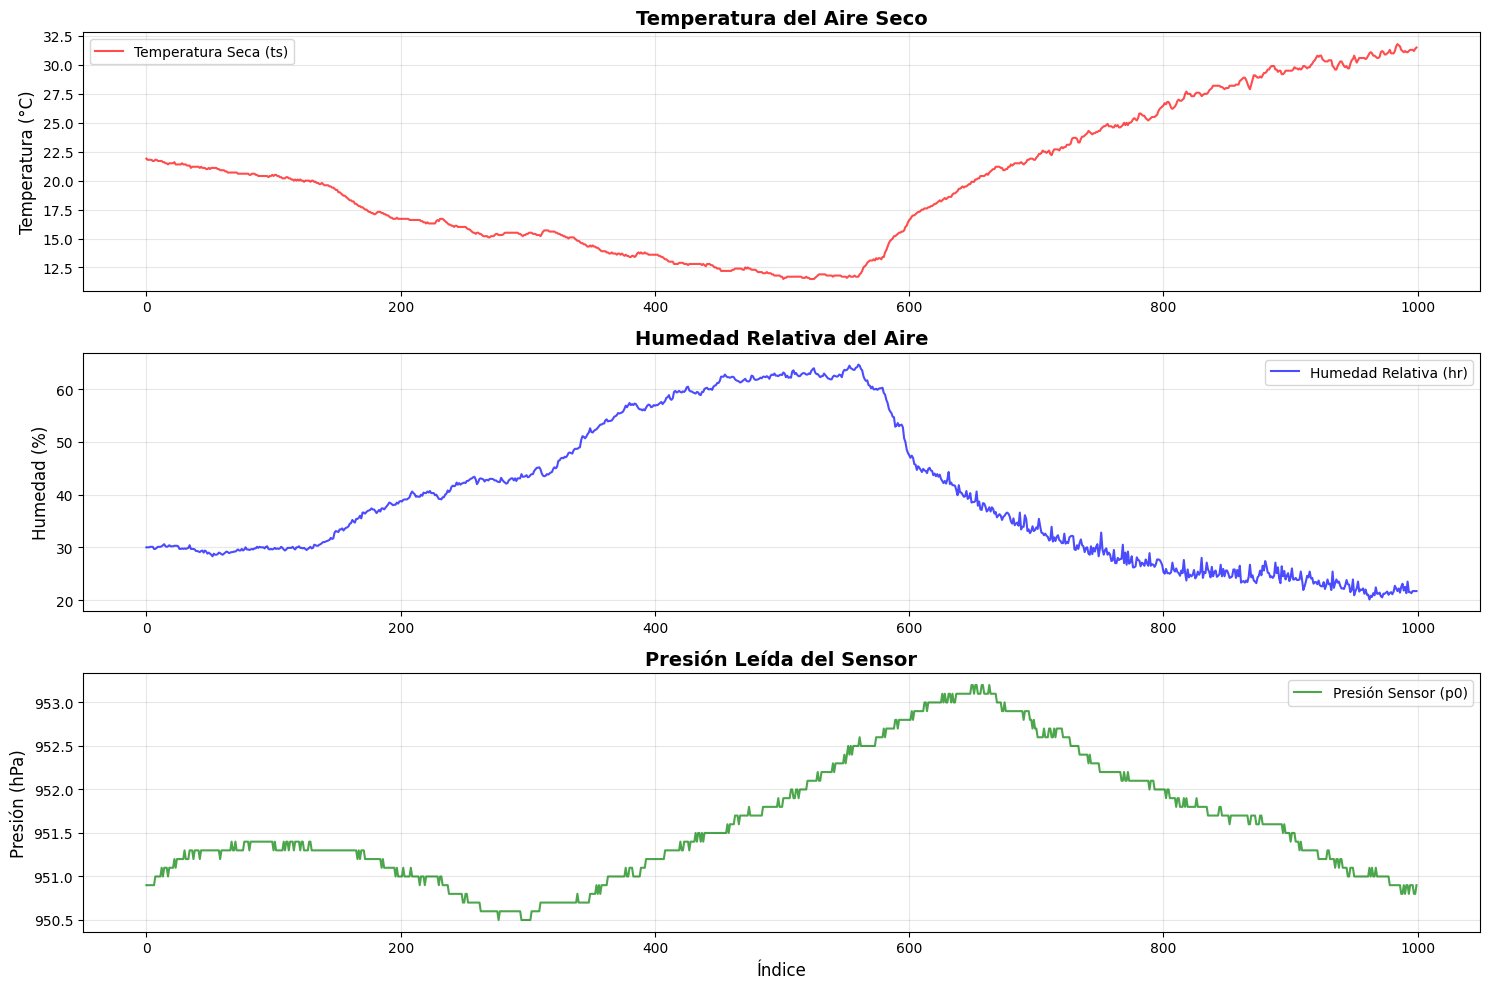

📊 Visualización de las primeras 1000 muestras de las 3 variables


In [21]:
# Visualizar distribución de las 3 variables
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Temperatura seca (ts)
axes[0].plot(df_selected['ts'][:1000], label='Temperatura Seca (ts)', color='red', alpha=0.7, linewidth=1.5)
axes[0].set_ylabel('Temperatura (°C)', fontsize=12)
axes[0].set_title('Temperatura del Aire Seco', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Humedad relativa (hr)
axes[1].plot(df_selected['hr'][:1000], label='Humedad Relativa (hr)', color='blue', alpha=0.7, linewidth=1.5)
axes[1].set_ylabel('Humedad (%)', fontsize=12)
axes[1].set_title('Humedad Relativa del Aire', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Presión (p0)
axes[2].plot(df_selected['p0'][:1000], label='Presión Sensor (p0)', color='green', alpha=0.7, linewidth=1.5)
axes[2].set_ylabel('Presión (hPa)', fontsize=12)
axes[2].set_xlabel('Índice', fontsize=12)
axes[2].set_title('Presión Leída del Sensor', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualización de las primeras 1000 muestras de las 3 variables")

In [22]:
# Escalado con StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print("✅ Datos escalados con StandardScaler")
print(f"   Shape escalado: {data_scaled.shape}")
print(f"   Media de cada feature: {scaler.mean_}")
print(f"   Desviación estándar:   {scaler.scale_}")

# Guardar el scaler para uso futuro
scaler_path = "scaler_3_features.pkl"
joblib.dump(scaler, scaler_path)
print(f"\n💾 Scaler guardado en: {scaler_path}")

✅ Datos escalados con StandardScaler
   Shape escalado: (3549541, 3)
   Media de cada feature: [ 16.59037105  59.48897101 955.49092561]
   Desviación estándar:   [ 7.80603333 23.97926202  3.35269374]

💾 Scaler guardado en: scaler_3_features.pkl


## 3. Crear secuencias para LSTM

In [23]:
def crear_secuencias(datos, n_pasos, columna_objetivo=0):
    """
    Crea secuencias de tiempo para entrenar el LSTM.
    
    Args:
        datos: Array con los datos escalados (n_samples, n_features)
        n_pasos: Número de timesteps en cada secuencia
        columna_objetivo: Índice de la columna a predecir (0 = ts)
    
    Returns:
        X: Secuencias de entrada (n_sequences, n_pasos, n_features)
        y: Valores objetivo (n_sequences,) - temperatura del siguiente paso
    """
    X, y = [], []
    for i in range(n_pasos, len(datos)):
        X.append(datos[i - n_pasos:i])  # Ventana de n_pasos
        y.append(datos[i, columna_objetivo])  # Temperatura ts del siguiente paso
    return np.array(X), np.array(y)

# Configuración
n_pasos = 24  # Usar las últimas 24 observaciones para predecir la siguiente
columna_ts = 0  # ts es la primera columna (índice 0)

X, y = crear_secuencias(data_scaled, n_pasos, columna_ts)

print(f"✅ Secuencias creadas")
print(f"   X shape: {X.shape} (secuencias, timesteps, features)")
print(f"   y shape: {y.shape} (secuencias,)")
print(f"   Timesteps: {n_pasos}")
print(f"   Features por timestep: {X.shape[2]} (ts, hr, p0)")
print(f"   Prediciendo: ts (Temperatura del Aire Seco)")

✅ Secuencias creadas
   X shape: (3549517, 24, 3) (secuencias, timesteps, features)
   y shape: (3549517,) (secuencias,)
   Timesteps: 24
   Features por timestep: 3 (ts, hr, p0)
   Prediciendo: ts (Temperatura del Aire Seco)


## 4. Dividir en entrenamiento y validación

In [24]:
# Dividir datos (80% entrenamiento, 20% validación)
split_ratio = 0.8
n_train = int(len(X) * split_ratio)

X_train, X_val = X[:n_train], X[n_train:]
y_train, y_val = y[:n_train], y[n_train:]

print(f"✅ División completada")
print(f"   Entrenamiento: {len(X_train):,} secuencias ({split_ratio*100:.0f}%)")
print(f"   Validación:    {len(X_val):,} secuencias ({(1-split_ratio)*100:.0f}%)")

✅ División completada
   Entrenamiento: 2,839,613 secuencias (80%)
   Validación:    709,904 secuencias (20%)


## 5. Construir el modelo LSTM

In [25]:
# Arquitectura del modelo
model = Sequential([
    # Primera capa LSTM con 128 unidades
    LSTM(128, return_sequences=True, input_shape=(n_pasos, X.shape[2])),
    Dropout(0.2),
    
    # Segunda capa LSTM con 64 unidades
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    
    # Capa de salida
    Dense(1)  # Predice 1 valor: temperatura del siguiente paso
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("✅ Modelo construido")
model.summary()

✅ Modelo construido


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenar el modelo

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'modelo_lstm_clima_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenar
print("🚀 Iniciando entrenamiento...\n")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1, # Deberian ser mas, pero 1 por el momento para comprobar que funciona
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\n✅ Entrenamiento completado")

🚀 Iniciando entrenamiento...

79577/88738 ━━━━━━━━━━━━━━━━━━━━ 2:30 16ms/step - loss: 0.0045 - mae: 0.0460

## 7. Visualizar resultados del entrenamiento

In [ ]:
# Graficar pérdida
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validación', linewidth=2)
axes[0].set_title('Pérdida del Modelo (MSE)', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validación', linewidth=2)
axes[1].set_title('Error Absoluto Medio (MAE)', fontsize=14)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Evaluar el modelo

In [ ]:
# Evaluar en conjunto de validación
loss, mae = model.evaluate(X_val, y_val, verbose=0)

print(f"📊 RESULTADOS EN VALIDACIÓN")
print(f"   Loss (MSE): {loss:.6f}")
print(f"   MAE:        {mae:.6f}")

# Hacer predicciones en validación
y_pred_scaled = model.predict(X_val, verbose=0)

# Invertir escalado para obtener temperaturas reales
# Crear array dummy con las 3 features
dummy_pred = np.zeros((len(y_pred_scaled), 3))
dummy_pred[:, 0] = y_pred_scaled.flatten()  # ts en columna 0
y_pred_real = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_val), 3))
dummy_true[:, 0] = y_val
y_true_real = scaler.inverse_transform(dummy_true)[:, 0]

# Calcular MAE en escala real
mae_real = np.mean(np.abs(y_pred_real - y_true_real))
print(f"\n🌡️  MAE en escala real: {mae_real:.3f} °C")

In [ ]:
# Visualizar predicciones vs valores reales
n_samples = 500  # Mostrar solo las primeras 500 predicciones

plt.figure(figsize=(15, 6))
plt.plot(y_true_real[:n_samples], label='Temperatura Real', linewidth=2, alpha=0.8)
plt.plot(y_pred_real[:n_samples], label='Temperatura Predicha', linewidth=2, alpha=0.8)
plt.title(f'Predicciones vs Valores Reales (Primeras {n_samples} muestras)', fontsize=14)
plt.xlabel('Índice')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Gráfica de comparación generada")

In [ ]:
# Scatter plot: predicho vs real
plt.figure(figsize=(8, 8))
plt.scatter(y_true_real[:5000], y_pred_real[:5000], alpha=0.3, s=5)
plt.plot([y_true_real.min(), y_true_real.max()], 
         [y_true_real.min(), y_true_real.max()], 
         'r--', linewidth=2, label='Predicción perfecta')
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 9. Predicción futura

In [ ]:
# Usar la última ventana disponible para predecir el siguiente valor
ultima_ventana = data_scaled[-n_pasos:].reshape(1, n_pasos, 3)

# Predecir
siguiente_pred_scaled = model.predict(ultima_ventana, verbose=0)[0][0]

# Invertir escalado
dummy_siguiente = np.zeros((1, 3))
dummy_siguiente[0, 0] = siguiente_pred_scaled
siguiente_temp = scaler.inverse_transform(dummy_siguiente)[0, 0]

ultima_temp_real = df_selected['ts'].iloc[-1]

print(f"🔮 PREDICCIÓN DEL SIGUIENTE PASO")
print(f"   Última temperatura real (ts):    {ultima_temp_real:.2f} °C")
print(f"   Temperatura predicha:            {siguiente_temp:.2f} °C")
print(f"   Diferencia:                      {siguiente_temp - ultima_temp_real:+.2f} °C")

## 10. Guardar modelo final

In [ ]:
# Guardar el modelo final
model_path = "modelo_lstm_3_features.h5"
model.save(model_path)

print(f"✅ ARCHIVOS GUARDADOS:")
print(f"   📦 Modelo:  {model_path}")
print(f"   📦 Scaler:  {scaler_path}")
print(f"\n🎉 ¡Entrenamiento completado exitosamente!")
print(f"\n📝 Configuración del modelo:")
print(f"   - Dataset:    dataset_ml.csv")
print(f"   - Features:   3 columnas (ts, hr, p0)")
print(f"   - Timesteps:  {n_pasos}")
print(f"   - MAE:        {mae_real:.3f} °C")
print(f"   - Objetivo:   Predecir 'ts' (Temperatura del Aire Seco)")
print(f"\n💡 Ahora puedes usar el modelo con 'predecir_simple.py'")